In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
%cd /content/drive/MyDrive/MyProject

/content/drive/MyDrive/MyProject


In [131]:
#checking the present working directory
!pwd

/content/drive/MyDrive/MyProject


In [60]:
#checking GPU availability
import torch
torch.cuda.is_available()

True

In [132]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(n_gpu)
torch.cuda.get_device_name(0)


1


'Tesla P100-PCIE-16GB'

In [62]:
# install huggingface Transformers
! pip install transformers


In [63]:
import transformers
print(transformers.__version__)

4.5.1


In [104]:
!pip install tqdm


In [106]:
from torch.utils.data import DataLoader, RandomSampler, random_split
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering, AdamW
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import json
from pathlib import Path
import os
import shutil
from tqdm import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline


In [65]:
! pwd
%mkdir dataset

/content/drive/MyDrive/MyProject
mkdir: cannot create directory ‘dataset’: File exists


##Finetuning BERT with SQUAD V2 Dataset##

In [66]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O dataset/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O dataset/dev-v2.0.json

--2021-05-08 17:58:40--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘dataset/train-v2.0.json’

dataset/train-v2.0. 100%[===================>]  40.17M  62.2MB/s    in 0.6s    

2021-05-08 17:58:45 (62.2 MB/s) - ‘dataset/train-v2.0.json’ saved [42123633/42123633]

--2021-05-08 17:58:45--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dataset/dev-v2.0.jso

In [134]:
#function to read the train and dev (test) json data
#please open the JSON file to see what is teh format thats being used in the json file
#reading the data as per the format is important 

#Each split is in a structured json file with a number of questions and answers for each passage (or context). 

def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers


In [135]:
#reading the train and dev json data

#The contexts and questions are just strings
#The answers are dicts containing the subsequence of the passage with the correct answer as well as an integer indicating the character at which the answer begins.

train_contexts, train_questions, train_answers = read_squad('dataset/train-v2.0.json')
val_contexts, val_questions, val_answers = read_squad('dataset/dev-v2.0.json')

In [136]:
#Since we already have the starting position for the answers...we need the character position where the answer is ending in the passage(context)

def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)



In [70]:
#Converting into a dataframe

examples = pd.DataFrame(
    {'contexts': train_contexts,
     'questions': train_questions
    })
answers=pd.DataFrame(train_answers)

In [71]:
final_data=pd.concat([examples,answers],axis=1)
final_data.head()


,contexts,questions,text,answer_start,answer_end
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269,286
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207,226
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526,530
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166,180
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276,286


In [72]:
final_data.isnull().values.any() #checking if there is any null or nan values in our dataframe/dataset

False

In [137]:
#Tokenizing the context and questions pairs
#We need to send tokenized inputs to the model. 

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

In [138]:
tokenizer("What is your name? My name is Barry Allen", "What is your name?")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 2026, 2171, 2003, 6287, 5297, 102, 2054, 2003, 2115, 2171, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [139]:
#converting the character start/end positions to token start/end positions

def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [140]:
#creating Dataset Object of encodings


class DatasetObject(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = DatasetObject(train_encodings)
val_dataset = DatasetObject(val_encodings)   #keeping the validation dataset for testing/evaluating

In [141]:
train_loader = DataLoader(train_dataset, batch_size=16,shuffle=True)

In [142]:
%mkdir model/checkpoint

In [143]:
import glob
checkpoints = sorted(glob.glob('/content/drive/MyDrive/MyProject/model/checkpoint*-[0-9]*'))

In [144]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [145]:
distil_bert="distilbert-base-uncased"

if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/content/drive/MyDrive/MyProject/model/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = DistilBertForQuestionAnswering.from_pretrained(distil_bert)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = DistilBertForQuestionAnswering.from_pretrained(distil_bert)

model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            

In [146]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[-0.0150, -0.0100,  0.0117,  ...,  0.0276,  0.0192, -0.0111],
        [ 0.0040,  0.0244, -0.0166,  ...,  0.0005, -0.0123, -0.0073]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [147]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [148]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [150]:
for epoch in range(3):
    # set model to train mode
    model.train()
    # setup loop (we use tqdm for the progress bar)
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all the tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        # train model on batch and return outputs (incl. loss)
        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)

        loss = outputs[0]
        train_loss_set.append(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        tr_loss += loss.item()
        optimizer.step()
        model.zero_grad()
        global_step += 1

        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
     
        if global_step % 1000 == 0:
          print("Train loss: {}".format(tr_loss/global_step))
          output_dir = '/content/drive/MyDrive/MyProject/model/checkpoint-{}'.format(global_step)
          if not os.path.exists(output_dir):
              os.makedirs(output_dir)
          model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
          model_to_save.save_pretrained(output_dir)
          torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
          print("Saving model checkpoint to %s" % output_dir)

Streaming output truncated to the last 5000 lines.




Epoch 0:  14%|█▍        | 762/5427 [05:43<35:12,  2.21it/s, loss=1.46]








Epoch 0:  14%|█▍        | 763/5427 [05:43<35:12,  2.21it/s, loss=1.46]








Epoch 0:  14%|█▍        | 763/5427 [05:44<35:12,  2.21it/s, loss=1.46]








Epoch 0:  14%|█▍        | 763/5427 [05:44<35:12,  2.21it/s, loss=1.67]








Epoch 0:  14%|█▍        | 764/5427 [05:44<35:08,  2.21it/s, loss=1.67]








Epoch 0:  14%|█▍        | 764/5427 [05:44<35:08,  2.21it/s, loss=1.67]








Epoch 0:  14%|█▍        | 764/5427 [05:44<35:08,  2.21it/s, loss=2.03]








Epoch 0:  14%|█▍        | 765/5427 [05:44<35:04,  2.22it/s, loss=2.03]








Epoch 0:  14%|█▍        | 765/5427 [05:45<35:04,  2.22it/s, loss=2.03]








Epoch 0:  14%|█▍        | 765/5427 [05:45<35:04,  2.22it/s, loss=1.24]








Epoch 0:  14%|█▍        | 766/5427 [05:45<35:02,  2.22it/s, loss=1.24]








Epoch 0:  14%|█▍        | 766/5427 [05:45<35:02,  2.22it/s, loss=1.24]







Train loss: 2.147646172106266











Epoch 0:  17%|█▋        | 948/5427 [07:07<52:37,  1.42it/s, loss=1.73]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-1000


Streaming output truncated to the last 5000 lines.




Epoch 0:  32%|███▏      | 1762/5427 [13:14<27:29,  2.22it/s, loss=0.972]








Epoch 0:  32%|███▏      | 1763/5427 [13:14<27:33,  2.22it/s, loss=0.972]








Epoch 0:  32%|███▏      | 1763/5427 [13:15<27:33,  2.22it/s, loss=0.972]








Epoch 0:  32%|███▏      | 1763/5427 [13:15<27:33,  2.22it/s, loss=2.15] 








Epoch 0:  33%|███▎      | 1764/5427 [13:15<27:35,  2.21it/s, loss=2.15]








Epoch 0:  33%|███▎      | 1764/5427 [13:15<27:35,  2.21it/s, loss=2.15]








Epoch 0:  33%|███▎      | 1764/5427 [13:15<27:35,  2.21it/s, loss=1.11]








Epoch 0:  33%|███▎      | 1765/5427 [13:15<27:30,  2.22it/s, loss=1.11]








Epoch 0:  33%|███▎      | 1765/5427 [13:16<27:30,  2.22it/s, loss=1.11]








Epoch 0:  33%|███▎      | 1765/5427 [13:16<27:30,  2.22it/s, loss=1.62]








Epoch 0:  33%|███▎      | 1766/5427 [13:16<27:26,  2.22it/s, loss=1.62]








Epoch 0:  33%|███▎      | 1766/5427 [13:16<27:26,  2.22it/s, 

Train loss: 1.8019717934429647











Epoch 0:  36%|███▌      | 1948/5427 [14:39<41:40,  1.39it/s, loss=2.19]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-2000


Streaming output truncated to the last 5000 lines.




Epoch 0:  51%|█████     | 2762/5427 [20:46<19:55,  2.23it/s, loss=1.49]








Epoch 0:  51%|█████     | 2763/5427 [20:46<19:59,  2.22it/s, loss=1.49]








Epoch 0:  51%|█████     | 2763/5427 [20:46<19:59,  2.22it/s, loss=1.49]








Epoch 0:  51%|█████     | 2763/5427 [20:46<19:59,  2.22it/s, loss=2.16]








Epoch 0:  51%|█████     | 2764/5427 [20:46<19:59,  2.22it/s, loss=2.16]








Epoch 0:  51%|█████     | 2764/5427 [20:46<19:59,  2.22it/s, loss=2.16]








Epoch 0:  51%|█████     | 2764/5427 [20:46<19:59,  2.22it/s, loss=1]   








Epoch 0:  51%|█████     | 2765/5427 [20:46<19:56,  2.22it/s, loss=1]








Epoch 0:  51%|█████     | 2765/5427 [20:47<19:56,  2.22it/s, loss=1]








Epoch 0:  51%|█████     | 2765/5427 [20:47<19:56,  2.22it/s, loss=1.28]








Epoch 0:  51%|█████     | 2766/5427 [20:47<19:55,  2.23it/s, loss=1.28]








Epoch 0:  51%|█████     | 2766/5427 [20:47<19:55,  2.23it/s, loss=1.28]

Train loss: 1.653227746874094











Epoch 0:  54%|█████▍    | 2948/5427 [22:11<40:16,  1.03it/s, loss=1.72]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-3000


Streaming output truncated to the last 5000 lines.




Epoch 0:  69%|██████▉   | 3762/5427 [28:17<12:25,  2.23it/s, loss=1.2]  








Epoch 0:  69%|██████▉   | 3763/5427 [28:17<12:25,  2.23it/s, loss=1.2]








Epoch 0:  69%|██████▉   | 3763/5427 [28:18<12:25,  2.23it/s, loss=1.2]








Epoch 0:  69%|██████▉   | 3763/5427 [28:18<12:25,  2.23it/s, loss=0.609]








Epoch 0:  69%|██████▉   | 3764/5427 [28:18<12:23,  2.24it/s, loss=0.609]








Epoch 0:  69%|██████▉   | 3764/5427 [28:18<12:23,  2.24it/s, loss=0.609]








Epoch 0:  69%|██████▉   | 3764/5427 [28:18<12:23,  2.24it/s, loss=0.73] 








Epoch 0:  69%|██████▉   | 3765/5427 [28:18<12:22,  2.24it/s, loss=0.73]








Epoch 0:  69%|██████▉   | 3765/5427 [28:19<12:22,  2.24it/s, loss=0.73]








Epoch 0:  69%|██████▉   | 3765/5427 [28:19<12:22,  2.24it/s, loss=1.13]








Epoch 0:  69%|██████▉   | 3766/5427 [28:19<12:24,  2.23it/s, loss=1.13]








Epoch 0:  69%|██████▉   | 3766/5427 [28:19<12:24,  2.23it/s, l

Train loss: 1.565467934384942











Epoch 0:  73%|███████▎  | 3948/5427 [29:42<17:51,  1.38it/s, loss=1.45]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-4000


Streaming output truncated to the last 5000 lines.




Epoch 0:  88%|████████▊ | 4762/5427 [35:49<04:59,  2.22it/s, loss=1.79] 








Epoch 0:  88%|████████▊ | 4763/5427 [35:49<04:58,  2.22it/s, loss=1.79]








Epoch 0:  88%|████████▊ | 4763/5427 [35:49<04:58,  2.22it/s, loss=1.79]








Epoch 0:  88%|████████▊ | 4763/5427 [35:49<04:58,  2.22it/s, loss=1.33]








Epoch 0:  88%|████████▊ | 4764/5427 [35:49<04:59,  2.22it/s, loss=1.33]








Epoch 0:  88%|████████▊ | 4764/5427 [35:49<04:59,  2.22it/s, loss=1.33]








Epoch 0:  88%|████████▊ | 4764/5427 [35:49<04:59,  2.22it/s, loss=1.49]








Epoch 0:  88%|████████▊ | 4765/5427 [35:49<04:58,  2.22it/s, loss=1.49]








Epoch 0:  88%|████████▊ | 4765/5427 [35:50<04:58,  2.22it/s, loss=1.49]








Epoch 0:  88%|████████▊ | 4765/5427 [35:50<04:58,  2.22it/s, loss=1.33]








Epoch 0:  88%|████████▊ | 4766/5427 [35:50<04:57,  2.22it/s, loss=1.33]








Epoch 0:  88%|████████▊ | 4766/5427 [35:50<04:57,  2.22it/s, los

Train loss: 1.5019426231503488











Epoch 0:  91%|█████████ | 4948/5427 [37:13<05:45,  1.39it/s, loss=1.48]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-5000


Streaming output truncated to the last 5000 lines.




Epoch 1:   6%|▌         | 335/5427 [02:31<38:12,  2.22it/s, loss=1.56]








Epoch 1:   6%|▌         | 336/5427 [02:31<38:07,  2.23it/s, loss=1.56]








Epoch 1:   6%|▌         | 336/5427 [02:31<38:07,  2.23it/s, loss=1.56]








Epoch 1:   6%|▌         | 336/5427 [02:31<38:07,  2.23it/s, loss=0.695]








Epoch 1:   6%|▌         | 337/5427 [02:31<38:08,  2.22it/s, loss=0.695]








Epoch 1:   6%|▌         | 337/5427 [02:32<38:08,  2.22it/s, loss=0.695]








Epoch 1:   6%|▌         | 337/5427 [02:32<38:08,  2.22it/s, loss=0.69] 








Epoch 1:   6%|▌         | 338/5427 [02:32<38:10,  2.22it/s, loss=0.69]








Epoch 1:   6%|▌         | 338/5427 [02:32<38:10,  2.22it/s, loss=0.69]








Epoch 1:   6%|▌         | 338/5427 [02:32<38:10,  2.22it/s, loss=0.692]








Epoch 1:   6%|▌         | 339/5427 [02:32<38:06,  2.22it/s, loss=0.692]








Epoch 1:   6%|▌         | 339/5427 [02:33<38:06,  2.22it/s, loss=0.692

Train loss: 1.4281903933634361











Epoch 1:  10%|▉         | 521/5427 [03:56<1:21:14,  1.01it/s, loss=0.986]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-6000


Streaming output truncated to the last 5000 lines.




Epoch 1:  25%|██▍       | 1335/5427 [10:03<30:38,  2.23it/s, loss=0.955]








Epoch 1:  25%|██▍       | 1336/5427 [10:03<30:31,  2.23it/s, loss=0.955]








Epoch 1:  25%|██▍       | 1336/5427 [10:04<30:31,  2.23it/s, loss=0.955]








Epoch 1:  25%|██▍       | 1336/5427 [10:04<30:31,  2.23it/s, loss=0.572]








Epoch 1:  25%|██▍       | 1337/5427 [10:04<30:34,  2.23it/s, loss=0.572]








Epoch 1:  25%|██▍       | 1337/5427 [10:04<30:34,  2.23it/s, loss=0.572]








Epoch 1:  25%|██▍       | 1337/5427 [10:04<30:34,  2.23it/s, loss=0.891]








Epoch 1:  25%|██▍       | 1338/5427 [10:04<30:36,  2.23it/s, loss=0.891]








Epoch 1:  25%|██▍       | 1338/5427 [10:05<30:36,  2.23it/s, loss=0.891]








Epoch 1:  25%|██▍       | 1338/5427 [10:05<30:36,  2.23it/s, loss=1.93] 








Epoch 1:  25%|██▍       | 1339/5427 [10:05<30:37,  2.22it/s, loss=1.93]








Epoch 1:  25%|██▍       | 1339/5427 [10:05<30:37,  2.22

Train loss: 1.355317515956504











Epoch 1:  28%|██▊       | 1521/5427 [11:28<48:31,  1.34it/s, loss=1.36]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-7000


Streaming output truncated to the last 5000 lines.




Epoch 1:  43%|████▎     | 2335/5427 [17:35<23:11,  2.22it/s, loss=0.767]








Epoch 1:  43%|████▎     | 2336/5427 [17:35<23:08,  2.23it/s, loss=0.767]








Epoch 1:  43%|████▎     | 2336/5427 [17:35<23:08,  2.23it/s, loss=0.767]








Epoch 1:  43%|████▎     | 2336/5427 [17:35<23:08,  2.23it/s, loss=0.995]








Epoch 1:  43%|████▎     | 2337/5427 [17:35<23:07,  2.23it/s, loss=0.995]








Epoch 1:  43%|████▎     | 2337/5427 [17:35<23:07,  2.23it/s, loss=0.995]








Epoch 1:  43%|████▎     | 2337/5427 [17:35<23:07,  2.23it/s, loss=0.749]








Epoch 1:  43%|████▎     | 2338/5427 [17:35<23:04,  2.23it/s, loss=0.749]








Epoch 1:  43%|████▎     | 2338/5427 [17:36<23:04,  2.23it/s, loss=0.749]








Epoch 1:  43%|████▎     | 2338/5427 [17:36<23:04,  2.23it/s, loss=1.03] 








Epoch 1:  43%|████▎     | 2339/5427 [17:36<23:06,  2.23it/s, loss=1.03]








Epoch 1:  43%|████▎     | 2339/5427 [17:36<23:06,  2.23

Train loss: 1.3027896724790335











Epoch 1:  46%|████▋     | 2521/5427 [18:59<36:03,  1.34it/s, loss=1.09]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-8000


Streaming output truncated to the last 5000 lines.




Epoch 1:  61%|██████▏   | 3335/5427 [25:06<15:41,  2.22it/s, loss=1.46]








Epoch 1:  61%|██████▏   | 3336/5427 [25:06<15:42,  2.22it/s, loss=1.46]








Epoch 1:  61%|██████▏   | 3336/5427 [25:06<15:42,  2.22it/s, loss=1.46]








Epoch 1:  61%|██████▏   | 3336/5427 [25:06<15:42,  2.22it/s, loss=0.844]








Epoch 1:  61%|██████▏   | 3337/5427 [25:06<15:41,  2.22it/s, loss=0.844]








Epoch 1:  61%|██████▏   | 3337/5427 [25:07<15:41,  2.22it/s, loss=0.844]








Epoch 1:  61%|██████▏   | 3337/5427 [25:07<15:41,  2.22it/s, loss=0.784]








Epoch 1:  62%|██████▏   | 3338/5427 [25:07<15:40,  2.22it/s, loss=0.784]








Epoch 1:  62%|██████▏   | 3338/5427 [25:07<15:40,  2.22it/s, loss=0.784]








Epoch 1:  62%|██████▏   | 3338/5427 [25:07<15:40,  2.22it/s, loss=0.603]








Epoch 1:  62%|██████▏   | 3339/5427 [25:07<15:40,  2.22it/s, loss=0.603]








Epoch 1:  62%|██████▏   | 3339/5427 [25:07<15:40,  2.22it

Train loss: 1.262663178079658











Epoch 1:  65%|██████▍   | 3521/5427 [26:31<32:25,  1.02s/it, loss=0.589]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-9000


Streaming output truncated to the last 5000 lines.




Epoch 1:  80%|███████▉  | 4335/5427 [32:38<08:13,  2.21it/s, loss=1.15]








Epoch 1:  80%|███████▉  | 4336/5427 [32:38<08:12,  2.21it/s, loss=1.15]








Epoch 1:  80%|███████▉  | 4336/5427 [32:38<08:12,  2.21it/s, loss=1.15]








Epoch 1:  80%|███████▉  | 4336/5427 [32:38<08:12,  2.21it/s, loss=1.41]








Epoch 1:  80%|███████▉  | 4337/5427 [32:38<08:12,  2.21it/s, loss=1.41]








Epoch 1:  80%|███████▉  | 4337/5427 [32:39<08:12,  2.21it/s, loss=1.41]








Epoch 1:  80%|███████▉  | 4337/5427 [32:39<08:12,  2.21it/s, loss=0.886]








Epoch 1:  80%|███████▉  | 4338/5427 [32:39<08:13,  2.21it/s, loss=0.886]








Epoch 1:  80%|███████▉  | 4338/5427 [32:39<08:13,  2.21it/s, loss=0.886]








Epoch 1:  80%|███████▉  | 4338/5427 [32:39<08:13,  2.21it/s, loss=0.611]








Epoch 1:  80%|███████▉  | 4339/5427 [32:39<08:11,  2.21it/s, loss=0.611]








Epoch 1:  80%|███████▉  | 4339/5427 [32:40<08:11,  2.21it/s,

Train loss: 1.2301642812475562











Epoch 1:  83%|████████▎ | 4521/5427 [34:02<11:43,  1.29it/s, loss=1.16]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-10000


Streaming output truncated to the last 5000 lines.



Epoch 1:  98%|█████████▊| 5336/5427 [40:09<00:41,  2.22it/s, loss=2.1]








Epoch 1:  98%|█████████▊| 5336/5427 [40:10<00:41,  2.22it/s, loss=2.1]








Epoch 1:  98%|█████████▊| 5336/5427 [40:10<00:41,  2.22it/s, loss=1.02]








Epoch 1:  98%|█████████▊| 5337/5427 [40:10<00:40,  2.22it/s, loss=1.02]








Epoch 1:  98%|█████████▊| 5337/5427 [40:10<00:40,  2.22it/s, loss=1.02]








Epoch 1:  98%|█████████▊| 5337/5427 [40:10<00:40,  2.22it/s, loss=0.659]








Epoch 1:  98%|█████████▊| 5338/5427 [40:10<00:40,  2.22it/s, loss=0.659]








Epoch 1:  98%|█████████▊| 5338/5427 [40:11<00:40,  2.22it/s, loss=0.659]








Epoch 1:  98%|█████████▊| 5338/5427 [40:11<00:40,  2.22it/s, loss=1.31] 








Epoch 1:  98%|█████████▊| 5339/5427 [40:11<00:39,  2.22it/s, loss=1.31]








Epoch 1:  98%|█████████▊| 5339/5427 [40:11<00:39,  2.22it/s, loss=1.31]








Epoch 1:  98%|█████████▊| 5339/5427 [40:11<00:39,  2.22it/s, los

Train loss: 1.2019768778180535











Epoch 2:   2%|▏         | 94/5427 [00:43<1:05:57,  1.35it/s, loss=0.664]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-11000


Streaming output truncated to the last 5000 lines.




Epoch 2:  17%|█▋        | 908/5427 [06:50<33:58,  2.22it/s, loss=0.447]








Epoch 2:  17%|█▋        | 909/5427 [06:50<33:54,  2.22it/s, loss=0.447]








Epoch 2:  17%|█▋        | 909/5427 [06:50<33:54,  2.22it/s, loss=0.447]








Epoch 2:  17%|█▋        | 909/5427 [06:50<33:54,  2.22it/s, loss=1.26] 








Epoch 2:  17%|█▋        | 910/5427 [06:50<33:59,  2.21it/s, loss=1.26]








Epoch 2:  17%|█▋        | 910/5427 [06:51<33:59,  2.21it/s, loss=1.26]








Epoch 2:  17%|█▋        | 910/5427 [06:51<33:59,  2.21it/s, loss=0.952]








Epoch 2:  17%|█▋        | 911/5427 [06:51<33:59,  2.21it/s, loss=0.952]








Epoch 2:  17%|█▋        | 911/5427 [06:51<33:59,  2.21it/s, loss=0.952]








Epoch 2:  17%|█▋        | 911/5427 [06:51<33:59,  2.21it/s, loss=1.5]  








Epoch 2:  17%|█▋        | 912/5427 [06:51<34:03,  2.21it/s, loss=1.5]








Epoch 2:  17%|█▋        | 912/5427 [06:52<34:03,  2.21it/s, loss=1.5]

Train loss: 1.1543337211658558











Epoch 2:  20%|██        | 1094/5427 [08:14<53:31,  1.35it/s, loss=0.732]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-12000


Streaming output truncated to the last 5000 lines.




Epoch 2:  35%|███▌      | 1908/5427 [14:21<26:23,  2.22it/s, loss=0.679]








Epoch 2:  35%|███▌      | 1909/5427 [14:21<26:27,  2.22it/s, loss=0.679]








Epoch 2:  35%|███▌      | 1909/5427 [14:22<26:27,  2.22it/s, loss=0.679]








Epoch 2:  35%|███▌      | 1909/5427 [14:22<26:27,  2.22it/s, loss=0.641]








Epoch 2:  35%|███▌      | 1910/5427 [14:22<26:27,  2.22it/s, loss=0.641]








Epoch 2:  35%|███▌      | 1910/5427 [14:22<26:27,  2.22it/s, loss=0.641]








Epoch 2:  35%|███▌      | 1910/5427 [14:22<26:27,  2.22it/s, loss=0.552]








Epoch 2:  35%|███▌      | 1911/5427 [14:22<26:25,  2.22it/s, loss=0.552]








Epoch 2:  35%|███▌      | 1911/5427 [14:22<26:25,  2.22it/s, loss=0.552]








Epoch 2:  35%|███▌      | 1911/5427 [14:23<26:25,  2.22it/s, loss=0.451]








Epoch 2:  35%|███▌      | 1912/5427 [14:23<26:21,  2.22it/s, loss=0.451]








Epoch 2:  35%|███▌      | 1912/5427 [14:23<26:21,  2.2

Train loss: 1.116001851557539











Epoch 2:  39%|███▊      | 2094/5427 [15:45<41:31,  1.34it/s, loss=1.11]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-13000


Streaming output truncated to the last 5000 lines.




Epoch 2:  54%|█████▎    | 2908/5427 [21:53<18:54,  2.22it/s, loss=0.384]








Epoch 2:  54%|█████▎    | 2909/5427 [21:53<18:54,  2.22it/s, loss=0.384]








Epoch 2:  54%|█████▎    | 2909/5427 [21:53<18:54,  2.22it/s, loss=0.384]








Epoch 2:  54%|█████▎    | 2909/5427 [21:53<18:54,  2.22it/s, loss=0.734]








Epoch 2:  54%|█████▎    | 2910/5427 [21:53<18:54,  2.22it/s, loss=0.734]








Epoch 2:  54%|█████▎    | 2910/5427 [21:54<18:54,  2.22it/s, loss=0.734]








Epoch 2:  54%|█████▎    | 2910/5427 [21:54<18:54,  2.22it/s, loss=0.713]








Epoch 2:  54%|█████▎    | 2911/5427 [21:54<18:55,  2.22it/s, loss=0.713]








Epoch 2:  54%|█████▎    | 2911/5427 [21:54<18:55,  2.22it/s, loss=0.713]








Epoch 2:  54%|█████▎    | 2911/5427 [21:54<18:55,  2.22it/s, loss=0.477]








Epoch 2:  54%|█████▎    | 2912/5427 [21:54<18:52,  2.22it/s, loss=0.477]








Epoch 2:  54%|█████▎    | 2912/5427 [21:54<18:52,  2.2

Train loss: 1.085401931441256











Epoch 2:  57%|█████▋    | 3094/5427 [23:17<30:13,  1.29it/s, loss=0.753]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-14000


Streaming output truncated to the last 5000 lines.




Epoch 2:  72%|███████▏  | 3908/5427 [29:24<11:24,  2.22it/s, loss=0.807]








Epoch 2:  72%|███████▏  | 3909/5427 [29:24<11:24,  2.22it/s, loss=0.807]








Epoch 2:  72%|███████▏  | 3909/5427 [29:25<11:24,  2.22it/s, loss=0.807]








Epoch 2:  72%|███████▏  | 3909/5427 [29:25<11:24,  2.22it/s, loss=0.545]








Epoch 2:  72%|███████▏  | 3910/5427 [29:25<11:26,  2.21it/s, loss=0.545]








Epoch 2:  72%|███████▏  | 3910/5427 [29:25<11:26,  2.21it/s, loss=0.545]








Epoch 2:  72%|███████▏  | 3910/5427 [29:25<11:26,  2.21it/s, loss=0.542]








Epoch 2:  72%|███████▏  | 3911/5427 [29:25<11:24,  2.22it/s, loss=0.542]








Epoch 2:  72%|███████▏  | 3911/5427 [29:25<11:24,  2.22it/s, loss=0.542]








Epoch 2:  72%|███████▏  | 3911/5427 [29:25<11:24,  2.22it/s, loss=0.658]








Epoch 2:  72%|███████▏  | 3912/5427 [29:25<11:23,  2.22it/s, loss=0.658]








Epoch 2:  72%|███████▏  | 3912/5427 [29:26<11:23,  2.2

Train loss: 1.0601941339542469











Epoch 2:  75%|███████▌  | 4094/5427 [30:49<22:58,  1.03s/it, loss=0.731]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-15000


Streaming output truncated to the last 5000 lines.




Epoch 2:  90%|█████████ | 4908/5427 [36:58<03:53,  2.23it/s, loss=0.713]








Epoch 2:  90%|█████████ | 4909/5427 [36:58<03:52,  2.23it/s, loss=0.713]








Epoch 2:  90%|█████████ | 4909/5427 [36:59<03:52,  2.23it/s, loss=0.713]








Epoch 2:  90%|█████████ | 4909/5427 [36:59<03:52,  2.23it/s, loss=0.74] 








Epoch 2:  90%|█████████ | 4910/5427 [36:59<03:52,  2.23it/s, loss=0.74]








Epoch 2:  90%|█████████ | 4910/5427 [36:59<03:52,  2.23it/s, loss=0.74]








Epoch 2:  90%|█████████ | 4910/5427 [36:59<03:52,  2.23it/s, loss=1.09]








Epoch 2:  90%|█████████ | 4911/5427 [36:59<03:52,  2.22it/s, loss=1.09]








Epoch 2:  90%|█████████ | 4911/5427 [36:59<03:52,  2.22it/s, loss=1.09]








Epoch 2:  90%|█████████ | 4911/5427 [36:59<03:52,  2.22it/s, loss=0.414]








Epoch 2:  91%|█████████ | 4912/5427 [36:59<03:53,  2.21it/s, loss=0.414]








Epoch 2:  91%|█████████ | 4912/5427 [37:00<03:53,  2.21it/s

Train loss: 1.0384699975373224











Epoch 2:  94%|█████████▍| 5094/5427 [38:23<04:26,  1.25it/s, loss=0.425]

Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-16000


Streaming output truncated to the last 5000 lines.




Epoch 2:  97%|█████████▋| 5242/5427 [39:29<01:23,  2.21it/s, loss=0.533]








Epoch 2:  97%|█████████▋| 5242/5427 [39:30<01:23,  2.21it/s, loss=0.533]








Epoch 2:  97%|█████████▋| 5242/5427 [39:30<01:23,  2.21it/s, loss=1.05] 








Epoch 2:  97%|█████████▋| 5243/5427 [39:30<01:22,  2.22it/s, loss=1.05]








Epoch 2:  97%|█████████▋| 5243/5427 [39:30<01:22,  2.22it/s, loss=1.05]








Epoch 2:  97%|█████████▋| 5243/5427 [39:30<01:22,  2.22it/s, loss=0.759]








Epoch 2:  97%|█████████▋| 5244/5427 [39:30<01:22,  2.21it/s, loss=0.759]








Epoch 2:  97%|█████████▋| 5244/5427 [39:31<01:22,  2.21it/s, loss=0.759]








Epoch 2:  97%|█████████▋| 5244/5427 [39:31<01:22,  2.21it/s, loss=0.811]








Epoch 2:  97%|█████████▋| 5245/5427 [39:31<01:22,  2.22it/s, loss=0.811]








Epoch 2:  97%|█████████▋| 5245/5427 [39:31<01:22,  2.22it/s, loss=0.811]








Epoch 2:  97%|█████████▋| 5245/5427 [39:31<01:22,  2.22i

In [159]:
# #Saving the Model
output_dir = '/content/drive/MyDrive/MyProject/model/checkpoint-final/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))

In [152]:
train_loss_set_ckpt = torch.load('/content/drive/MyDrive/MyProject/model/checkpoint-final/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

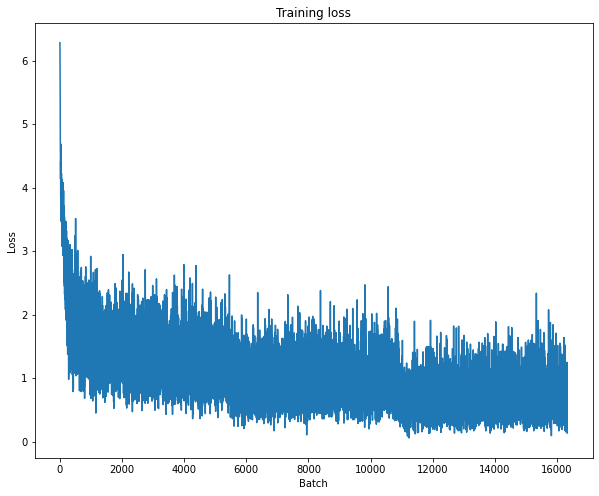

In [153]:
plt.figure(figsize=(10,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Evaluating the Finetuned Model after training**

In [154]:
val_loader = DataLoader(val_dataset,batch_size=16,shuffle=True)

In [158]:
acc = []
# switch model out of training mode
model.eval()

# initialize loop for progress bar
loop = tqdm(val_loader)
# loop through batches
for batch in loop:
    # we don't need to calculate gradients as we're not training
    with torch.no_grad():
        # pull batched items from loader
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)
        # make predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        # getting the predictions
        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)
        # calculate accuracy for both and append to accuracy list
        acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_true).sum()/len(end_pred)).item())

Streaming output truncated to the last 5000 lines.




 56%|█████▋    | 714/1269 [01:44<01:21,  6.78it/s]








 56%|█████▋    | 715/1269 [01:44<01:21,  6.79it/s]








 56%|█████▋    | 716/1269 [01:44<01:21,  6.79it/s]








 57%|█████▋    | 717/1269 [01:44<01:21,  6.80it/s]








 57%|█████▋    | 718/1269 [01:45<01:20,  6.81it/s]








 57%|█████▋    | 719/1269 [01:45<01:20,  6.82it/s]








 57%|█████▋    | 720/1269 [01:45<01:20,  6.82it/s]








 57%|█████▋    | 721/1269 [01:45<01:20,  6.80it/s]








 57%|█████▋    | 722/1269 [01:45<01:20,  6.81it/s]








 57%|█████▋    | 723/1269 [01:45<01:20,  6.81it/s]








 57%|█████▋    | 724/1269 [01:46<01:19,  6.85it/s]








 57%|█████▋    | 725/1269 [01:46<01:19,  6.81it/s]








 57%|█████▋    | 726/1269 [01:46<01:19,  6.85it/s]








 57%|█████▋    | 727/1269 [01:46<01:19,  6.85it/s]








 57%|█████▋    | 728/1269 [01:46<01:18,  6.86it/s]








 57%|█████▋    | 729/1269 [01:46<01:18,  6.85it/s]








 

In [160]:
# calculate average accuracy in total
acc = sum(acc)/len(acc)
print("The Test Accuracy is {}".format(acc*100))

The Test Accuracy is 65.190532479444


###Ask Question###

In [ ]:
question = "How many parameters does BERT-large have?"
answer_text = "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."